# Strategies for estimating a model performance


In [3]:

# This study was motivated by this discussion. The question was about strategies for estimating model performance on unseen data. This may not be a question straightforward to answer because we have several variables to think about and assumptions to be made. Although this is not a Titanic kernel, I had to find a home for it. Hopefully you'll find the results useful or at least entertaining.

# One possible strategy is to leave a portion of the train data out that is not touched during training. This is typically used in one of the last steps to check how well our model does with guaranteed unseen data. The remaining data is used to tune the model using K-Fold cross validation (CV). K-Fold CV also outputs information about how well it may do with unseen data. However, a valid concern is that in K-Fold CV we no longer have guaranteed unseed data by design. The question is how CV and hold-out compare with each other.

# Statistically, since the hold-out set is typically smaller than the entire CV set, it should suffer from more variance. I thought then about a theorem in the discussion. It states that as long as the partitions are statistically very similar (more so in an information-theoretical sense), the estimation for unseen data using a hold-out set should give the same average estimate as in the cross validation. If that's the case, CV only would then suffice. The approach might be objectionable if we absolutely don't want to use data that has been used during training to forcast performance of unseen data. It is really a design choice. Hopefully we may see pros and cons. This topic is also discussed by DanB in this tutorial notebook. We provide here a controlled experimental platform.

# Since mathematical proofs are quite abstract, this notebook tests the theorem in practice with synthesized data. This way we can precisely control the data and understand the laws and mechanisms behind.

# The synthesized data has four independent features A, B, C and D. Each may take the discrete values {0,1,2,3}. A class is then associated by the following non-linear formula CLASS = A + BC + AD. We then generate a data frame with this rule. Next, 20% of the rows have features randomly scrambled. With this, if a classifier is trained on this data, we expect 80% of classification precision. Let's then examine what happens...

# Creating independent features A, B, C and D

# Creating data frame

# Adding classification errors
# Defining partitions
# Training a classifier
# Results
# Conclusions


<AxesSubplot:title={'center':'A'}>

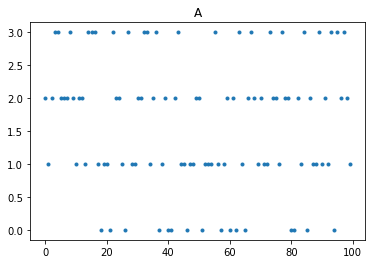

In [4]:
import pandas as pd
import numpy as np
from random import shuffle
from matplotlib import pyplot as plt
# Creating independent features A, B, C and D 
# Each feature may assume a values in {0,1,2,3}. They are subsequently shuffled to make them independent.

def gen_features():
    a_levels  = 4     # number of levels per feature
    a_len     = 16000 # number of instances per feature
    A = [ i % a_levels for i in range(a_len)]
    B = [ i % a_levels for i in range(a_len)]
    C = [ i % a_levels for i in range(a_len)]
    D = [ i % a_levels for i in range(a_len)]
    shuffle(A)
    shuffle(B)
    shuffle(C)
    shuffle(D)
    return A, B, C, D
# Creating data frame 
# We define the CLASS by the non-linear relation CLASS = A + BC + AD. Let's make the classifier job not too easy by avoiding a simple linear relation!

def gen_df():
    A, B, C, D = gen_features()
    df = pd.DataFrame({'A':A,'B':B,'C':C,'D':D})
    df['CLASS'] = df['A'] + df['B']*df['C'] + df['A']*df['D']
    return df

df = gen_df()
df.head(10)
# A	B	C	D	CLASS
# 0	2	1	0	2	6
# 1	3	1	1	2	10
# 2	0	3	2	1	6
# 3	2	2	3	1	10
# 4	1	2	1	1	4
# 5	2	1	1	2	7
# 6	3	0	1	0	3
# 7	2	3	0	1	4
# 8	1	2	1	3	6
# 9	0	2	1	3	2
# Inspecting the first 100 rows of feature A
df['A'][0:100].plot(title='A', style='.')
 


In [5]:
# Adding classification errors 
# We shuffle 20% of the rows. This should create about 20% of classification errors with respect to the "ground truth" formula. We then add a GOOD indicator to mark rows that still follows our non-linear formula.

def add_errors(df):
    # shuffle the first shuffle_feature rows for each feature 20%
    shuffle_features = int(df.shape[0] * 0.20)
    shuffle(df['A'][0:shuffle_features])
    shuffle(df['B'][0:shuffle_features])
    shuffle(df['C'][0:shuffle_features])
    shuffle(df['D'][0:shuffle_features])
    return df

df = add_errors(df)

def add_marker(df):
    # create a marker for tracking rows that no longer follows the non-linear relation
    df['GOOD'] = (df['A'] + df['B']*df['C'] + df['A']*df['D']) == df['CLASS'] 
    df['GOOD'].replace([True,False],[1,0],inplace = True)
    return df

df = add_marker(df)
df.head(10)    


,A,B,C,D,CLASS,GOOD
0,0,3,1,3,8,0
1,3,2,3,3,4,0
2,3,0,0,2,8,0
3,1,1,3,2,6,1
4,3,0,2,3,9,0
5,1,2,0,2,8,0
6,3,0,2,1,2,0
7,1,0,1,1,8,0
8,1,2,2,0,5,1
9,3,2,0,2,4,0


<AxesSubplot:title={'center':'CLASS'}>

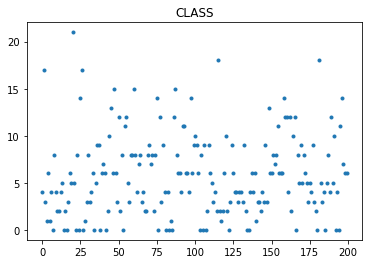

In [6]:
# Shuffle entire data frame rows
# We shuffle again the entire data frame to spread the concentration of classification errors at the top of the data frame.

df = df.sample(frac=1).reset_index(drop=True)
df['CLASS'][0:200].plot(title='CLASS',style='.')



In [7]:

# Although we shuffle 20% of the rows, some may still end up following the formula. We compute the percentage that still follows the formula.

print('Whole set true mean classification accuracy {0:2.4f}'.format(df['GOOD'].mean()))
#Whole set true mean classification accuracy 0.8153
# Defining partitions 
# We are now ready to set partitions up. We first reserve 80% of the data to emulate unseen data. It is a large enough portion to be of statistical significance. The remaining 20% (df2) is what is left for the "data scientist" to work with. Next we reserve 10% of df2 for hold-out. We may at this point calculate the expected accuracy in the unseen data and the hold-out set. Recall that we expect the accuracy to be 80% by design. Differences are caused by the hold-out sampling. With the default settings, you'll see hold out has great variance because of its small size (please run this kernel multiple times to verify).

from sklearn.model_selection import train_test_split

# reserving emulated unseen data. df2 is what's visible for the "data scientist"
df2, unseen = train_test_split(df, test_size=0.8)

# let's leave 10% data out for hold-out
train, hold_out = train_test_split(df2,test_size=0.10)
print(train.shape)
print(hold_out.shape)
print('hold out true mean classification accuracy {0:2.4f}'.format(hold_out['GOOD'].mean()))
print('unseen   true mean classification accuracy {0:2.4f}'.format(unseen['GOOD'].mean()))
# (2880, 6)
# (320, 6)
# hold out true mean classification accuracy 0.8531
# unseen   true mean classification accuracy 0.8130



Whole set true mean classification accuracy 0.8174
(2880, 6)
(320, 6)
hold out true mean classification accuracy 0.8063
unseen   true mean classification accuracy 0.8160


In [8]:

# We now compute the expected accuracy for the remaining of the train set. This will be typically closer to the whole set true mean accuracy than the hold-out estimate by the law-of-large-numbers. A random seed is not set in this script so you may verify the outcome for multiple runs and verify the claims in this notebook. A single run won't cut it!

print('train (cv) true mean classification accuracy {0:2.4f}'.format(train['GOOD'].mean()))
# train (cv) true mean classification accuracy 0.8208
# Training a classifier 
# We will now train a KNeighborsClassifier. The tunable parameters are n_neighbors and the minkowski metric parameter p.


train (cv) true mean classification accuracy 0.8247


In [14]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knclass = KNeighborsClassifier(n_neighbors=11, metric = 'minkowski')

kn_param_grid={'n_neighbors':[3,5,7,9,11], 'p':[1,1.5,2]}

gs = GridSearchCV(knclass, kn_param_grid, cv = 5, return_train_score = True, n_jobs=4)

gs.fit(X=np.array(train[['A','B','C','D']]), y = np.array(train['CLASS']))

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform'),
       #fit_params=None, 
       #fit_params ={ 'eval_set': [(test_x, test_y)],
       iid=True, n_jobs=4,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 1.5, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

# Let's print the best tuned parameters
gs.best_params_
# {'n_neighbors': 7, 'p': 1}

# Unseen data
# Let's see first how our model does with our simulated unseen data


{'n_neighbors': 5, 'p': 1.5}

In [18]:
unseen_data_score = gs.score(unseen[['A','B','C','D']],unseen['CLASS'])
print('accuracy of the model on unseen data {0:2.4f}'.format(unseen_data_score))
# accuracy of the model on unseen data 0.8063
# Let's also print the train score
# These are usually expected to have higher precision than the test score (computed next) because the train portion is typically overfit. I encourage the understanding of the contents of "cvresults" and avoiding using GridSearchCV as a black-box. It contains many useful statistics.

gs.cv_results_['mean_train_score']
# array([ 0.78568959,  0.78568959,  0.78568959,  0.81623808,  0.81623808,
#         0.81623808,  0.81745104,  0.81719017,  0.81719017,  0.81102537,
#         0.81128624,  0.81128624,  0.80165048,  0.80208526,  0.80208526])


accuracy of the model on unseen data 0.8089


array([0.79696181, 0.79696181, 0.79696181, 0.82013889, 0.8203125 ,
       0.8203125 , 0.82039931, 0.82039931, 0.82039931, 0.81388889,
       0.81388889, 0.81354167, 0.80182292, 0.80182292, 0.80069444])

In [19]:
# Let's now print the test score
# This is the indicator for the performance of the model for unseen data using the cross validation technique. The bigger the gap with the train score the more overfit your model is.

# cross validation score
cv_best_score = gs.best_score_
gs.cv_results_['mean_test_score']
# array([ 0.77638889,  0.77638889,  0.77638889,  0.80972222,  0.80972222,
#         0.80972222,  0.81180556,  0.81145833,  0.81145833,  0.79305556,
#         0.79340278,  0.79340278,  0.77465278,  0.77569444,  0.77569444])
# Results 
# hold-out score
# We compare the model score on the hold-out set and on unseen data.

# hold out score
hold_out_score = gs.score(hold_out[['A','B','C','D']], hold_out['CLASS'])
print('Accuracy by model on hold-out {0:2.4f}; accuracy by model on unseen {1:2.4f}'.format(hold_out_score, unseen_data_score))
# Accuracy by model on hold-out 0.8406; accuracy by model on unseen 0.8063
# CV score
# We compare the model score on CV data and on unseen data. It is good with the added advantage that is statistically more sound since it is based on a larger portion of the data. Despite potential concerns that using all data might be bad for estimating performance on unseen data.

print('Accuracy by model on CV       {0:2.4f}; accuracy by model on unseen {1:2.4}'.format(cv_best_score, unseen_data_score))
# Accuracy by model on CV       0.8118; accuracy by model on unseen 0.8063
# Let's now repeat the above process a number of times to obtain more statistically significant results.

def one_run():
    # create base data frame
    df = gen_df()
    df = add_errors(df)
    df = add_marker(df)
    df = df.sample(frac=1).reset_index(drop=True)
    
    # make partitions
    df2,   unseen   = train_test_split(df, test_size= 0.8)
    train, hold_out = train_test_split(df2,test_size= 0.1)
    
    # grid search and fit
    gs.fit(X=np.array(train[['A','B','C','D']]), y = np.array(train['CLASS']))
    
    # compute hold out score
    hold_out_score = gs.score(hold_out[['A','B','C','D']], hold_out['CLASS'])
    
    # compute cv score
    cv_best_score = gs.best_score_
    
    # compute unseen score
    unseen_score = gs.score(unseen[['A','B','C','D']], unseen['CLASS'])
    
    return unseen_score, cv_best_score, hold_out_score

n_loops = 30
result = np.empty([n_loops,3],dtype=float)

for i in range(n_loops):
    result[i,:] = np.array(one_run())
    print('round {3:2}   unseen {0:2.4f}  CV {1:2.3f} hold-out {2:2.3f}'.format(result[i,0],result[i,1],result[i,2],i))
    


Accuracy by model on hold-out 0.8031; accuracy by model on unseen 0.8089
Accuracy by model on CV       0.8090; accuracy by model on unseen 0.8089
round  0   unseen 0.8027  CV 0.790 hold-out 0.809
round  1   unseen 0.8113  CV 0.799 hold-out 0.809
round  2   unseen 0.8057  CV 0.798 hold-out 0.800
round  3   unseen 0.8055  CV 0.794 hold-out 0.838
round  4   unseen 0.8063  CV 0.791 hold-out 0.809
round  5   unseen 0.8061  CV 0.803 hold-out 0.787
round  6   unseen 0.8172  CV 0.798 hold-out 0.831
round  7   unseen 0.8055  CV 0.814 hold-out 0.850
round  8   unseen 0.7970  CV 0.817 hold-out 0.794
round  9   unseen 0.8067  CV 0.812 hold-out 0.791
round 10   unseen 0.7947  CV 0.795 hold-out 0.831
round 11   unseen 0.7989  CV 0.807 hold-out 0.778
round 12   unseen 0.8066  CV 0.817 hold-out 0.794
round 13   unseen 0.8057  CV 0.809 hold-out 0.816
round 14   unseen 0.8080  CV 0.815 hold-out 0.787
round 15   unseen 0.8109  CV 0.794 hold-out 0.778
round 16   unseen 0.8082  CV 0.797 hold-out 0.819
roun

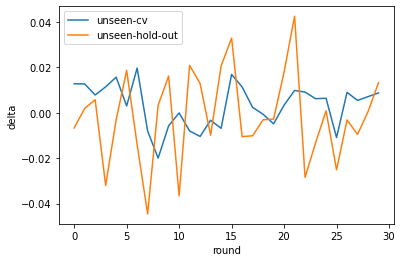

In [20]:
plt.plot(result[:,0]-result[:,1],label='unseen-cv')
plt.plot(result[:,0]-result[:,2],label='unseen-hold-out')
plt.xlabel('round')
plt.ylabel('delta')
plt.legend()




In [21]:

print('cv                      mean error:', np.mean(result[:,0]-result[:,1]))
print('cv        error standard deviation:', np.std(result[:,0]-result[:,1]))
print('hold out                mean error:', np.mean(result[:,0]-result[:,2]))
print('hold out  error standard deviation:', np.std(result[:,0]-result[:,2]))
# cv                      mean error: 0.00385040509259
# cv        error standard deviation: 0.0109918043719
# hold out                mean error: -0.000200520833333
# hold out  error standard deviation: 0.0266376898687


cv                      mean error: 0.0032951388888888935
cv        error standard deviation: 0.00933918688986146
hold out                mean error: -0.0015312499999999914
hold out  error standard deviation: 0.019679888574961935


In [ ]:
# We verify that using K-fold cv yields a better estimate than using a hold-out for this controlled data set.

# Conclusions 
# We demonstrated the implications of the "partition theorem". It says K-Fold CV is sufficient for the estimation of unseen data without a need for a separate hold-out set when the partitions are information-theoretically similar. Not only that, but CV estimate might be more accurate on average as a consequence of the law of large numbers. The similarity requirement might be a big "if" for small sets, however, it demonstrates assumptions and recommendations must be carefully examined and understood. Please don't just accept them as irrefutable! I'm also eager to hear about counter examples. Lastly, I believe a number of other interesting conclusions can be drawn from the theorem.

# Thank you for reading and please let me know about any comments!